# Characterizing Context of Attacks:
 - Are attacks isolated events, or do they occur in series?
 - Are the product of provocateurs or a toxic environment?
 - Do they occur on certain topics ?
 - Is toxic behaviour reciprocated ? 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from load_utils import *

In [2]:
d = load_diffs()
df_events, df_blocked_user_text = load_block_events_and_users()

### Q: Is tone reciprocal?

Methodology 1: is the average aggression score of what A says on B's page related to the average score of what B says on A's page?

In [3]:
pairs = d['2015'].query('not own_page and not author_anon and not recipient_anon')\
                     .groupby(['user_text', 'page_title'], as_index = False)['pred_aggression_score']\
                     .agg({'aggresssivness': np.mean, 'count': len})\
                     .query('count > 5')\
                     .assign(key = lambda x: 'From:' + x['user_text'] + ' to:' + x['page_title'],
                                partner_key = lambda x: 'From:' + x['page_title'] + ' to:' + x['user_text']
                               )
            
       
        
pairs = pairs.merge(pairs, left_on = 'partner_key', right_on = 'key', how = 'inner' )

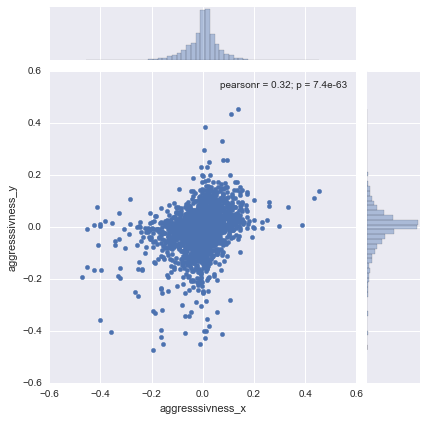

In [4]:
sns.jointplot(x = 'aggresssivness_x', y = 'aggresssivness_y', data = pairs)

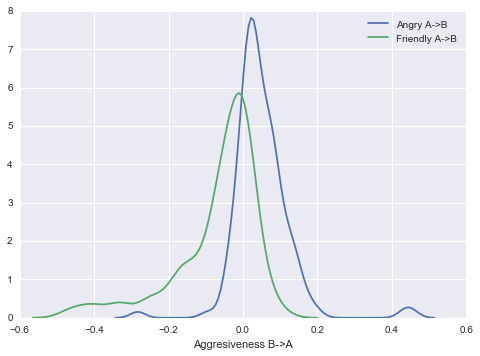

In [5]:
t_angry = np.percentile(pairs['aggresssivness_x'], 95)
t_friendly = np.percentile(pairs['aggresssivness_y'], 5)

sns.distplot(pairs.query('aggresssivness_x > %f' % t_angry)['aggresssivness_y'], hist=False, label = 'Angry A->B')
sns.distplot(pairs.query('aggresssivness_x < %f' % t_friendly)['aggresssivness_y'], hist=False, label = 'Friendly A->B')
plt.xlabel('Aggresiveness B->A')

Methodology 2: is the aggression score of what A says on B's page related to the score of the next thing B says on A's page?

In [7]:
cols =  ['user_text', 'page_title', 'pred_aggression_score', 'rev_timestamp', 'rev_id']
ab = d['2015'].query('not own_page and not author_anon and not recipient_anon')[cols]
ba = ab.copy().rename(columns = {'user_text': 'page_title', 'page_title': 'user_text'})[cols]

micro_pairs = ab.merge(ba, on = ['user_text', 'page_title'], how = 'inner' )\
                .assign(delta = lambda x: x['rev_timestamp_x'] - x['rev_timestamp_y'])\
                .assign(delta_positive = lambda x: x.delta >  pd.Timedelta('0 seconds'),
                        delta_less_30 = lambda x: x.delta <  pd.Timedelta('30 days'))\
                .query('delta_positive and delta_less_30')\
                .sort('delta', ascending=False)\
                .groupby('rev_id_x', as_index=False).first()

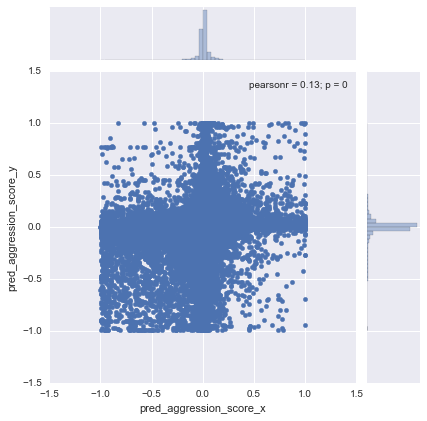

In [8]:
sns.jointplot(x = 'pred_aggression_score_x', y = 'pred_aggression_score_y', data = micro_pairs)

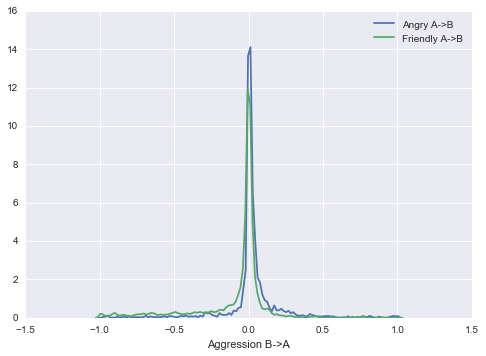

In [9]:
t_friendly, t_neutral, t_angry = np.percentile(micro_pairs['pred_aggression_score_x'], (5, 50, 95))


sns.distplot(micro_pairs.query('pred_aggression_score_x > %f' % t_angry)['pred_aggression_score_y'], hist=False, label = 'Angry A->B')
sns.distplot(micro_pairs.query('pred_aggression_score_x < %f' % t_friendly)['pred_aggression_score_y'], hist=False, label = 'Friendly A->B')

plt.xlabel('Aggression B->A')

### Q: Saintliness vs. Provocativeness

In [16]:
out_score = d['2015'].query('not own_page and not author_anon and not recipient_anon')\
                     .groupby(['user_text'], as_index = False)['pred_aggression_score']\
                     .agg({'out_score': np.mean, 'count': len})\
                     .query('count > 5')
            
in_score = d['2015'].query('not own_page and not author_anon and not recipient_anon')\
                     .groupby(['page_title'], as_index = False)['pred_aggression_score']\
                     .agg({'in_score': np.mean, 'count': len})\
                     .query('count > 5')\
                     .rename(columns = {'page_title':'user_text'})
                    
in_out = out_score.merge(in_score, how = 'inner', on = 'user_text')
in_out['saintliness'] = in_out['out_score'] - in_out['in_score']

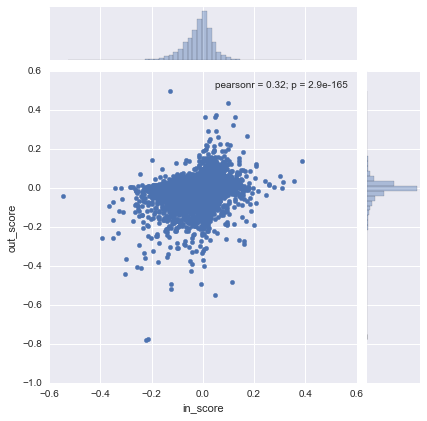

In [17]:
sns.jointplot(x = 'in_score', y = 'out_score', data = in_out)

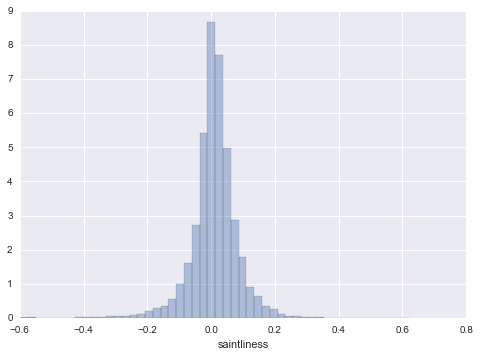

In [18]:
sns.distplot(in_out['saintliness'].dropna(), kde =False, norm_hist = True)

In [19]:
# Saints
in_out.sort_values('saintliness').head(5)

,user_text,count_x,out_score,in_score,count_y,saintliness
4612,Not So Dumb Blond,7.0,-0.551200,0.046581,9.0,-0.597780
2288,GMTEgirl,6.0,-0.479936,0.115900,7.0,-0.595835
6511,Tremonist,22.0,-0.772576,-0.215693,14.0,-0.556884
4991,Pjoef,37.0,-0.777911,-0.221516,21.0,-0.556395
2711,Hmlarson,68.0,-0.490855,-0.006114,19.0,-0.484741


In [20]:
# Saints
in_out.sort_values('saintliness').query('in_score > 0 and out_score < 0' ).head(5)

,user_text,count_x,out_score,in_score,count_y,saintliness
4612,Not So Dumb Blond,7.0,-0.551200,0.046581,9.0,-0.597780
2288,GMTEgirl,6.0,-0.479936,0.115900,7.0,-0.595835
519,Asdiprizio,14.0,-0.289732,0.162422,6.0,-0.452154
3690,Lbhiggin,19.0,-0.270775,0.162247,8.0,-0.433022
4805,Parenchyma18,12.0,-0.265710,0.142385,6.0,-0.408095


In [26]:
#d['2015'].query("user_text == 'Parenchyma18'")

In [22]:
# Saints
in_out.sort_values('saintliness').query('in_score > 0 and out_score < 0' ).head(5)

,user_text,count_x,out_score,in_score,count_y,saintliness
4612,Not So Dumb Blond,7.0,-0.551200,0.046581,9.0,-0.597780
2288,GMTEgirl,6.0,-0.479936,0.115900,7.0,-0.595835
519,Asdiprizio,14.0,-0.289732,0.162422,6.0,-0.452154
3690,Lbhiggin,19.0,-0.270775,0.162247,8.0,-0.433022
4805,Parenchyma18,12.0,-0.265710,0.142385,6.0,-0.408095


In [23]:
# Provocateurs
in_out.sort_values('saintliness', ascending = False).head(5)

,user_text,count_x,out_score,in_score,count_y,saintliness
4225,Missionedit,566.0,0.496392,-0.126938,181.0,0.623330
3559,Koavf,435.0,-0.038425,-0.544188,11.0,0.505764
2996,JackETC,7.0,0.367135,0.010317,8.0,0.356818
3277,Jono52795,10.0,0.001214,-0.344283,6.0,0.345496
1915,Ellasexygandara,8.0,0.144595,-0.199697,7.0,0.344292


In [24]:
# Provocateurs
in_out.sort_values('saintliness', ascending = False).query('out_score > 0 and in_score < 0').head(5)

,user_text,count_x,out_score,in_score,count_y,saintliness
4225,Missionedit,566.0,0.496392,-0.126938,181.0,0.623330
3277,Jono52795,10.0,0.001214,-0.344283,6.0,0.345496
1915,Ellasexygandara,8.0,0.144595,-0.199697,7.0,0.344292
5635,Satya durga reddy,13.0,0.072588,-0.243677,6.0,0.316265
3662,Langcliffe,12.0,0.007866,-0.285251,7.0,0.293116
